<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/main/BiasCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from scipy import stats


In [2]:
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

# Hypothesis

## Bias against

Model

In [ ]:

mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_0, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_0, posterior_mean, posterior_var**0.5))
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

### Analytic (using posterior density)

In [ ]:
bias_against = idata.posterior['logBR_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)

### Simulation (estimating marginal likelihood)

In [ ]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)


#### Plot

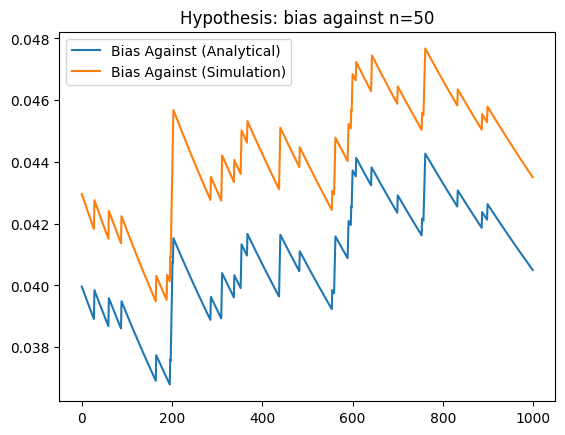

In [ ]:
plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: bias against n=50")
plt.legend()

## Bias in favor in **1D**

In [ ]:
mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
delta = 0.05
mu_lower = mu_0 - delta
mu_upper = mu_0 + delta
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    xl_ = pm.Normal('xl_', mu=mu_lower, sigma=1, shape=n)
    xu_ = pm.Normal('xu_', mu=mu_upper, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)

    posterior_meanl = (mu_prior_mean/mu_prior_sigma**2 + xl_.sum()/1)*posterior_var
    posterior_meanu = (mu_prior_mean/mu_prior_sigma**2 + xu_.sum()/1)*posterior_var

    posterior_prior_pdl = pm.Deterministic("posterior_prior_pdl",
                                          normal_logp(mu_0, posterior_meanl, posterior_var**0.5))
    posterior_prior_pdu = pm.Deterministic("posterior_prior_pdu",
                                          normal_logp(mu_0, posterior_meanu, posterior_var**0.5))

    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_prior_pdl-prior_prior_pd) # pm.math.exp()
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_prior_pdu-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pdlower = pm.Deterministic("likelihood_prior_pdlower", normal_logp(xl_,mu_0,1).sum())
    likelihood_prior_pdupper = pm.Deterministic("likelihood_prior_pdupper", normal_logp(xu_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)

use = 1000
marginal_likelihoodslower = np.zeros(list(idata.posterior['xl_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoodslower[:,:,:,i] = normal_logp_np(idata.posterior['xl_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoodsupper = np.zeros(list(idata.posterior['xu_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoodsupper[:,:,:,i] = normal_logp_np(idata.posterior['xu_'].values,m,1)


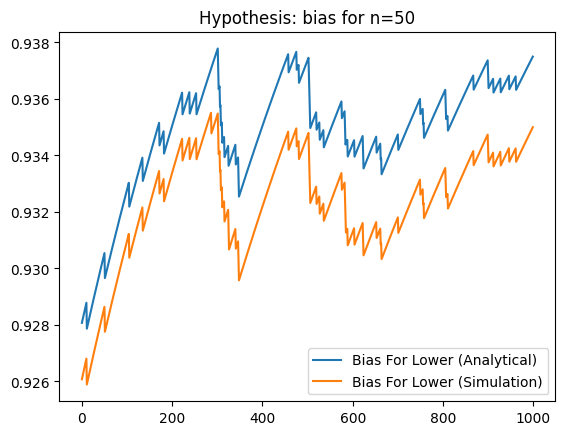

In [ ]:
marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoodslower.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mllower = (idata.posterior['likelihood_prior_pdlower'].values.ravel()-marginal_likelihoods_lower) > 0
bias_for_ml_mcilower = bias_for_mllower.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

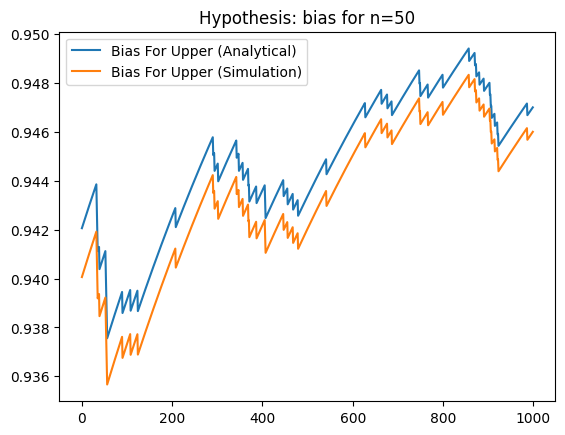

In [ ]:
marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoodsupper.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_for_mlupper = (idata.posterior['likelihood_prior_pdupper'].values.ravel()-marginal_likelihoods_upper) > 0
bias_for_ml_mciupper = bias_for_mlupper.cumsum()/np.arange(1,tl+1)

plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

#### Another example for bias in favor

Using specification from Example 2 in this paper, where true value of bias in favor is 0.692:

Michael Evans (2016),Measuring statistical evidence using relative belief,
Computational and Structural Biotechnology Journal,
Volume 14, Pages 91-96, ISSN 2001-0370,
https://doi.org/10.1016/j.csbj.2015.12.001.

Explictly

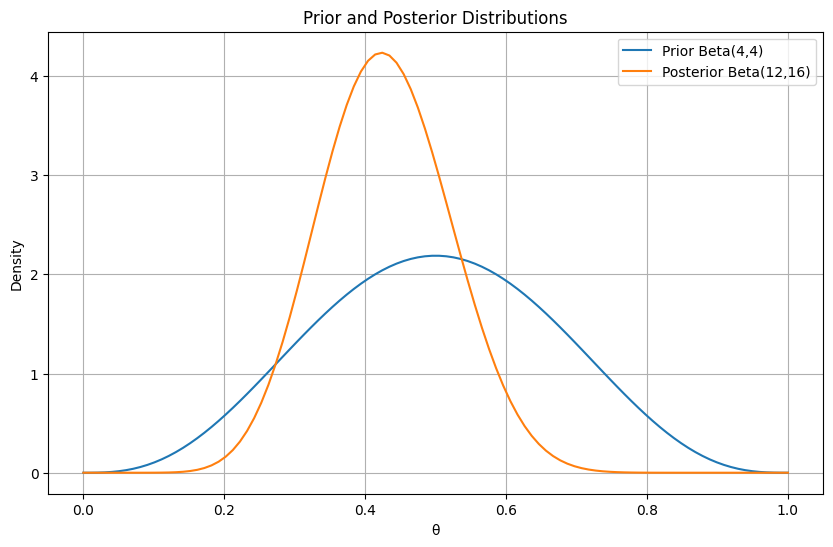

Bias in favor of H0 at θ* = 0.45: 0.403
Bias in favor of H0 at θ* = 0.55: 0.098


In [31]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the observed data
x = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])

# Compute the number of successes (heads)
nx = 8 #np.sum(x)
n = 20 #len(x)

# Define the Beta prior parameters
alpha0 = 4
beta0 = 4

# Compute the posterior distribution parameters
alpha_post = nx + alpha0
beta_post = n - nx + beta0

# Define the range of theta values
theta = np.linspace(0, 1, 100)

# Compute the prior and posterior densities
prior_density = stats.beta.pdf(theta, alpha0, beta0)
posterior_density = stats.beta.pdf(theta, alpha_post, beta_post)

# Plot the prior and posterior distributions
plt.figure(figsize=(10, 6))
plt.plot(theta, prior_density, label='Prior Beta(4,4)')
plt.plot(theta, posterior_density, label='Posterior Beta(12,16)')
plt.xlabel('θ')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions')
plt.legend()
plt.grid(True)
plt.show()


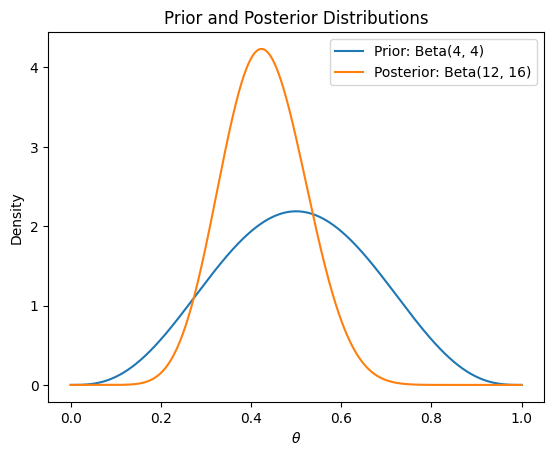

Bayes Factor RB(1/2 | x): 1.421017783028739
0.95-Credible Region: (0.2547988066317378, 0.6120160697403181)
Length of the credible region: 0.35721726310858026
Probability RB(theta | x) <= RB(0.5 | x) given nx=8: 0.30931
Bias against H0: θ = 1/2: 0.165626


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.special import gamma

# Given data
x = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])
n = len(x)
n_x = np.sum(x)

# Prior parameters
alpha_0 = 4
beta_0 = 4

# Posterior parameters
alpha_post = n_x + alpha_0
beta_post = n - n_x + beta_0

# Plotting the prior and posterior distributions
theta = np.linspace(0, 1, 1000)
prior = beta.pdf(theta, alpha_0, beta_0)
posterior = beta.pdf(theta, alpha_post, beta_post)

plt.plot(theta, prior, label=f'Prior: Beta({alpha_0}, {beta_0})')
plt.plot(theta, posterior, label=f'Posterior: Beta({alpha_post}, {beta_post})')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions')
plt.legend()
plt.show()



import math

def beta_distribution(x, a, b):
    return (math.gamma(a + b) / (math.gamma(a) * math.gamma(b))) * (x ** (a - 1)) * ((1 - x) ** (b - 1))

def bayes_factor(theta, nx, n, alpha0, beta0):
    return (beta_distribution(theta, nx + alpha0, n - nx + beta0)) / (beta_distribution(theta, alpha0, beta0))

def probability_rb_less_than_given(theta, nx, n, alpha0, beta0, threshold):
    count = 0
    samples = 100000
    for _ in range(samples):
        random_theta = np.random.beta(nx + alpha0, n - nx + beta0)
        if bayes_factor(random_theta, nx, n, alpha0, beta0) <= threshold:
            count += 1
    return count / samples

# Given data
nx = 8
n = 20
alpha0 = 4
beta0 = 4

RB_theta_0 =bayes_factor(0.5, nx, n, alpha0, beta0)

print("Bayes Factor RB(1/2 | x):", RB_theta_0)
# Calculate the 0.95-credible region
credible_region = beta.interval(0.95, alpha_post, beta_post)
credible_region_length = credible_region[1] - credible_region[0]
print(f"0.95-Credible Region: {credible_region}")
print(f"Length of the credible region: {credible_region_length}")
print("Probability RB(theta | x) <= RB(0.5 | x) given nx=8:", probability_rb_less_than_given(0.5, nx, n, alpha0, beta0, RB_theta_0))



def bias_against_H0(theta, nx, n, alpha0, beta0):
    count = 0
    samples = 1000000
    for _ in range(samples):
        random_theta = np.random.beta(nx + alpha0, n - nx + beta0)
        if bayes_factor(random_theta, nx, n, alpha0, beta0) <= 1:
            count += 1
    return count / samples

# Given data
theta0 = 0.5
bias = bias_against_H0(theta0, nx, n, alpha0, beta0)

print("Bias against H0: θ = 1/2:", bias)



Analytically (Using posterior density)

In [24]:
delta = 0.05
n = 20
theta0 = 0.5
data1 = np.random.binomial(1, theta0-delta, n)
data2 = np.random.binomial(1,theta0+delta, n)

alpha0 = 4
beta0 = 4

print(data1)
print(data2)

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    posterior_pd1 = pm.Beta('posterior_pd1', alpha = np.sum(data1)+alpha0, beta = n-np.sum(data1)+beta0)
    posterior_pd2 = pm.Beta('posterior_pd2', alpha = np.sum(data2)+alpha0, beta = n-np.sum(data2)+beta0)

    BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior_pd1/theta)
    BR_prior_pd2 = pm.Deterministic("BR_prior_pd2", posterior_pd2/theta)

    # Likelihood for data1
    p_data1 = pm.math.switch(data1, theta, 1 - theta)
    likelihood_data1 = pm.Deterministic("likelihood_data1", pm.math.prod(p_data1))

    # Likelihood for data2
    p_data2 = pm.math.switch(data2, theta, 1 - theta)
    likelihood_data2 = pm.Deterministic("likelihood_data2", pm.math.prod(p_data2))


    # Sample from posterior
    trace = pm.sample(2000, tune=1000)

bias_forlower = trace.posterior['BR_prior_pd1'].values.ravel() > 1
bias_forupper = trace.posterior['BR_prior_pd2'].values.ravel() > 1
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1)
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1)



[0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1]
[0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 1]


In [18]:
marginal_likelihoods_lower = np.zeros((2000, 1000))  # Assuming 2000 samples in the posterior
for i, m in enumerate(trace.posterior['xl_'].values.reshape(-1)[:1000]):
    marginal_likelihoods_lower[i] = np.prod(np.random.binomial(n=1, p=m, size=data1.shape))

marginal_likelihoods_upper = np.zeros((2000, 1000))  # Assuming 2000 samples in the posterior
for i, m in enumerate(trace.posterior['xu_'].values.reshape(-1)[:1000]):
    marginal_likelihoods_upper[i] = np.prod(np.random.binomial(n=1, p=m, size=data2.shape))

print("Shape of marginal_likelihoodslower:", marginal_likelihoods_lower.shape)



Shape of marginal_likelihoodslower: (2000, 1000)


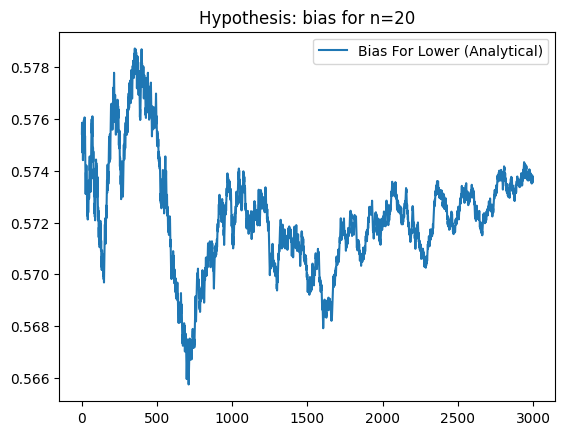

In [25]:
#marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=0))
#bias_for_mllower = (trace.posterior['likelihood_data1'].values.ravel()/marginal_likelihoods_lower) > 1
#bias_for_ml_mcilower = bias_for_mllower.cumsum()/np.arange(1,tlower+1)

plt.plot(bias_forlower_mci[burn:], label='Bias For Lower (Analytical)')
#plt.plot(bias_for_ml_mcilower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

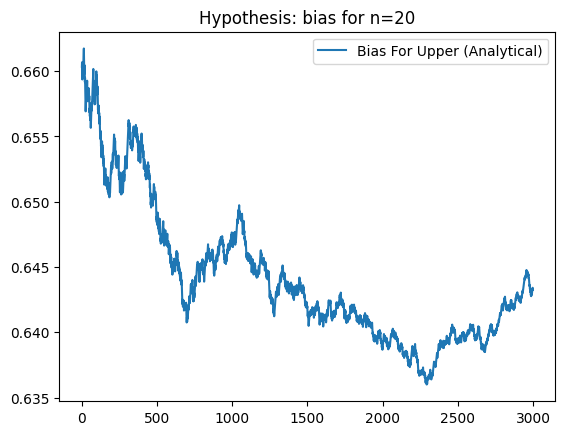

In [26]:
#marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoodsupper).mean(axis=0))
#bias_for_mlupper = (trace.posterior['likelihood_data2'].values.ravel()-marginal_likelihoods_upper) > 0
#bias_for_ml_mciupper = bias_for_mlupper.cumsum()/np.arange(1,tupper+1)

plt.plot(bias_forupper_mci[burn:], label='Bias For Upper (Analytical)')
#plt.plot(bias_for_ml_mciupper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()

# Estimation

Model

In [ ]:
n = 50
x = stats.norm.rvs(size=n)
mu_prior_mean = 0
mu_prior_sigma = 1
with pm.Model() as m:

    # traditional analysis
    mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_, posterior_mean, posterior_var**0.5))
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_,1).sum())

with m:
    idata = pm.sample(draws=1000) #Makes meginal likelihood estimation more accurate)

## Bias against

### Analytic (using posterior density)

In [ ]:
bias_against = idata.posterior['logRB_prior_pd'].values.ravel()<=0
t = bias_against.shape[0]
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
burn = 1000


### Simulation (Estimating marginal likelihood)

In [ ]:
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1)
marginal_likelihoods = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel())

bias_against = idata.posterior['logRB_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)


bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)


#### Plot

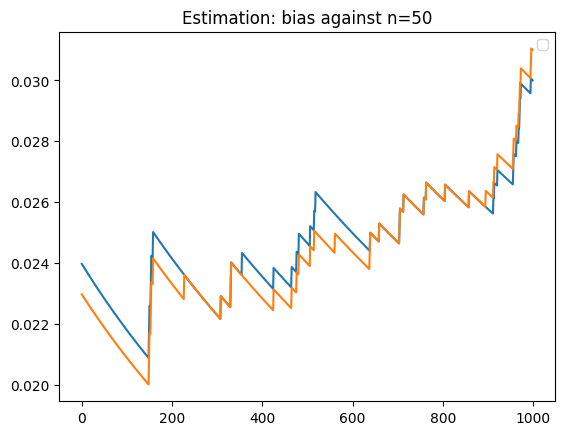

In [ ]:
plt.plot(bias_against_mci[burn:])
plt.plot(bias_against_ml_mci[burn:]);
plt.title("Estimation: bias against n={}".format(n))
plt.legend()

## Bias in favor in 1D

### Analytic (Using posterior density)

In [ ]:
#Not done yet

### Simulation (Estimating marginal likelihood)

In [ ]:
#Not done yet

# Relative Belief ratios

In [ ]:
np.random.seed(1234)
data = np.random.uniform(0, 10, size=100)
with pm.Model() as model:
    # Prior
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    # Sample posterior
    trace = pm.sample(2000, tune=1000)

# Extract posterior samples
posterior_samples = trace.posterior['mu'].values.flatten()




<ipython-input-8-87221d08c27d>:40: RuntimeWarning: invalid value encountered in divide
  rbr = smoothed_posterior_hist / smoothed_prior_hist


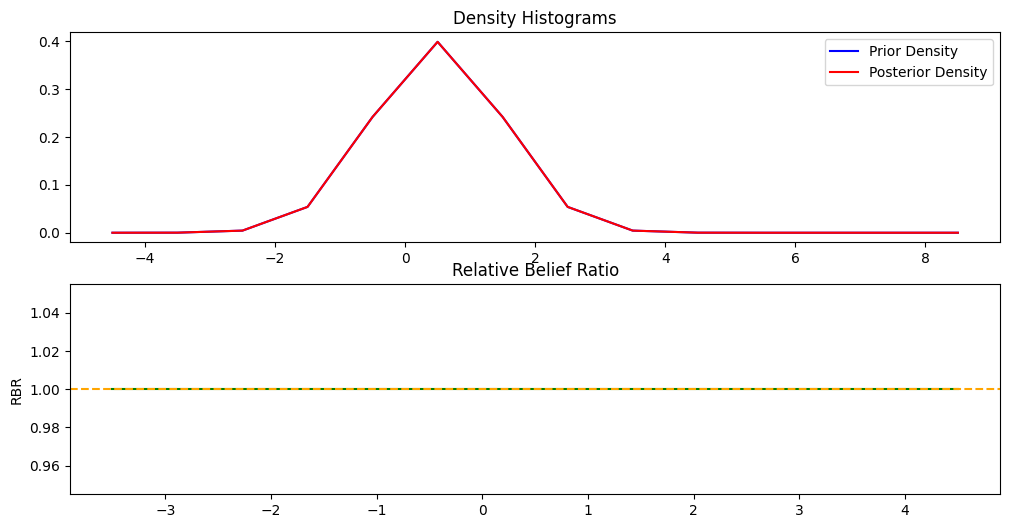

In [ ]:
n = 100
theta0 = 0.5
data = np.random.binomial(1, theta0, n)

alpha0 = 4
beta0 = 4

# Create the PyMC3 model
with pm.Model() as modBias:
    # Prior distribution
    theta_prior = pm.Beta('theta', alpha=alpha0, beta=beta0)

    # Likelihood
    likelihood = pm.Binomial('likelihood', n=n, p=theta0, observed=data)

    # Posterior distribution
    posterior = pm.Beta('posterior', alpha=np.sum(data) + alpha0, beta=n - np.sum(data) + beta0)

    # Calculate the ratio of posterior to prior
    #BR_prior_pd1 = pm.Deterministic("BR_prior_pd1", posterior / theta_prior)

    # Sample the model
    trace = pm.sample(2000, tune=1000)

delta = 1
bins = np.arange(-5, 10, delta)

# Prior histogram
prior_samples = np.random.beta(alpha0, beta0, size=10000)
prior_hist, _ = np.histogram(prior_samples, bins=bins, density=True)

# Posterior histogram
posterior_hist, _ = np.histogram(trace.posterior['posterior'], bins=bins, density=True)

# Smoothing
smoothed_prior_hist = gaussian_filter1d(prior_hist, sigma=1)
smoothed_posterior_hist = gaussian_filter1d(posterior_hist, sigma=1)

# Compute RBR by taking ratio
rbr = smoothed_posterior_hist / smoothed_prior_hist

# Plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bin_centers, smoothed_prior_hist, label='Prior Density', color='blue')
plt.plot(bin_centers, smoothed_posterior_hist, label='Posterior Density', color='red')
plt.legend()
plt.title('Density Histograms')

plt.subplot(2, 1, 2)
plt.plot(bin_centers, rbr, color='green')
plt.title('Relative Belief Ratio')
plt.ylabel('RBR')
plt.axhline(y=1, color='orange', linestyle='--')
plt.show()

### Analytic (Using posterior and prior ratio)

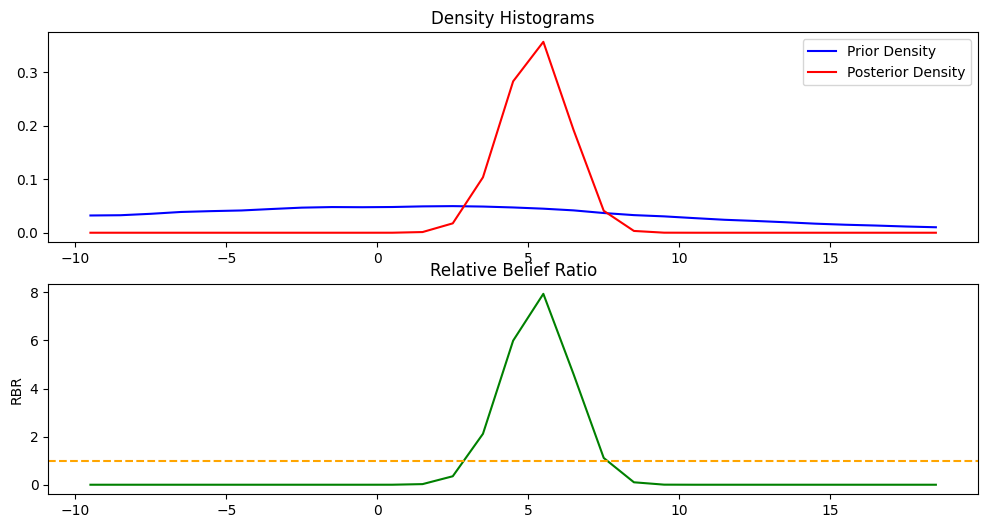

In [ ]:
delta = 1 #Meaningful difference
bins = np.arange(-10, 20, delta)

# Prior histogram
prior_samples = np.random.normal(0, 10, size=10000)
prior_hist, _ = np.histogram(prior_samples, bins=bins, density=True)

# Posterior histogram
posterior_hist, _ = np.histogram(posterior_samples, bins=bins, density=True)

# Smoothing
smoothed_prior_hist = gaussian_filter1d(prior_hist, sigma=1)
smoothed_posterior_hist = gaussian_filter1d(posterior_hist, sigma=1)

# Compute RBR by taking ratio
rbr = smoothed_posterior_hist / smoothed_prior_hist

# Plotting
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(bin_centers, smoothed_prior_hist, label='Prior Density', color='blue')
plt.plot(bin_centers, smoothed_posterior_hist, label='Posterior Density', color='red')
plt.legend()
plt.title('Density Histograms')

plt.subplot(2, 1, 2)
plt.plot(bin_centers, rbr, color='green')
plt.title('Relative Belief Ratio')
plt.ylabel('RBR')
plt.axhline(y=1, color='orange', linestyle='--')
plt.show()


### Simulation

In [ ]:
#Not done yet